In [2]:
!pip install -Uqq fastbook

ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

voila 0.2.6 requires nbconvert<7,>=6.0.0, but you'll have nbconvert 5.6.1 which is incompatible.


In [31]:
import fastbook
fastbook.setup_book()

In [32]:
from fastbook import *
from fastai.vision.widgets import *

In [33]:
key = os.environ.get('AZURE_SEARCH_KEY', '2f3ac973a52746f09f241fbb6213bf51')

In [34]:
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128, max_images=150)>

In [35]:
 def search_images_bing(key, term, max_images: int = 200, **kwargs):    
     params = {'q':term, 'count':max_images}
     headers = {"Ocp-Apim-Subscription-Key":key}
     search_url = "https://api.bing.microsoft.com/v7.0/images/search"
     response = requests.get(search_url, headers=headers, params=params)
     response.raise_for_status()
     search_results = response.json()    
     return L(search_results['value'])

In [36]:
results = search_images_bing(key, 'adidas shoe', min_sz=128)
ims = results.attrgot('contentUrl')
len(ims)

150

In [37]:
shoe_types = 'nike','adidas','reebok'
path = Path('shoes')

In [38]:
shoe_types

('nike', 'adidas', 'reebok')

In [39]:
path.exists()

False

In [41]:
if not path.exists():
    path.mkdir()
    for o in shoe_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} shoe')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [42]:
fns = get_image_files(path)
fns

(#429) [Path('shoes/nike/00000000.jpg'),Path('shoes/nike/00000004.jpeg'),Path('shoes/nike/00000006.jpg'),Path('shoes/nike/00000001.jpg'),Path('shoes/nike/00000009.jpg'),Path('shoes/nike/00000010.jpg'),Path('shoes/nike/00000011.jpg'),Path('shoes/nike/00000002.jpg'),Path('shoes/nike/00000012.jpg'),Path('shoes/nike/00000003.jpg')...]

In [43]:
failed = verify_images(fns)
failed

(#6) [Path('shoes/nike/00000020.jpg'),Path('shoes/nike/00000056.jpg'),Path('shoes/nike/00000031.jpg'),Path('shoes/adidas/00000008.jpg'),Path('shoes/adidas/00000104.jpg'),Path('shoes/reebok/00000016.jpg')]

In [44]:
failed.map(Path.unlink);

In [45]:
shoes = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.3, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [46]:
dls = shoes.dataloaders(path)

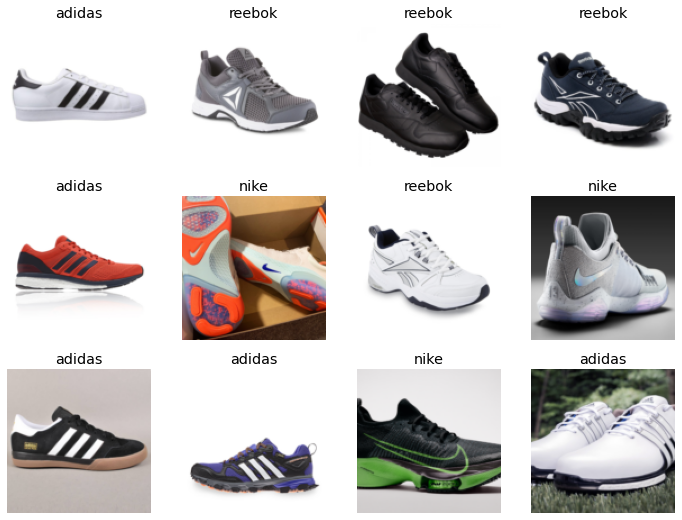

In [47]:
dls.valid.show_batch(max_n=12,nrows=3)

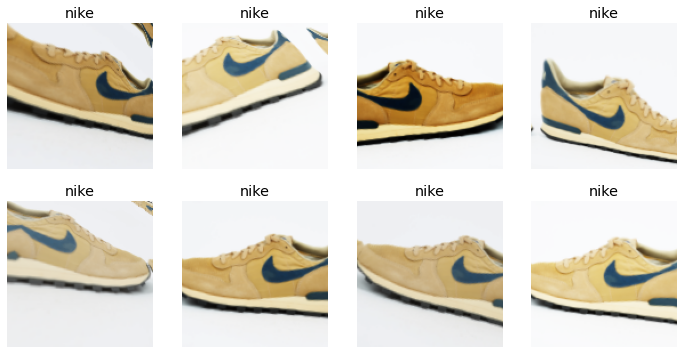

In [48]:
shoes = shoes.new(item_tfms=Resize(128),batch_tfms=aug_transforms(mult=2))
dls = shoes.dataloaders(path)
dls.train.show_batch(max_n=8,nrows=2,unique=True)

In [49]:
shoes = shoes.new(
    item_tfms=RandomResizedCrop(224,min_scale=0.5),
    batch_tfms=aug_transforms())
dls = shoes.dataloaders(path)

In [50]:
learn = cnn_learner(dls,resnet18,metrics=error_rate)
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,2.099104,1.317784,0.523810,00:09


epoch,train_loss,valid_loss,error_rate,time
0,1.330377,1.002808,0.444444,00:10
1,1.148117,0.754522,0.357143,00:10
2,0.999355,0.662832,0.301587,00:11
3,0.878490,0.641867,0.238095,00:10
4,0.799384,0.641890,0.261905,00:09


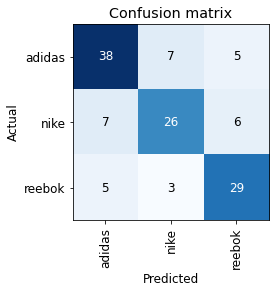

In [51]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

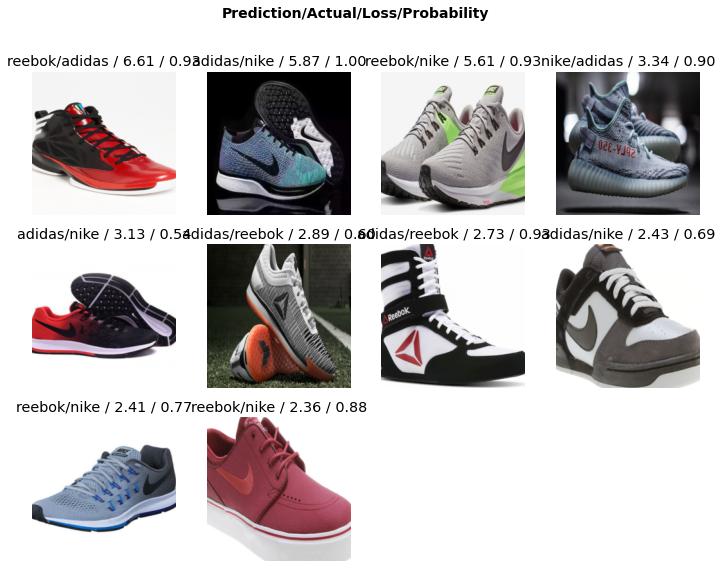

In [52]:
interp.plot_top_losses(10, nrows=3)

In [53]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [54]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

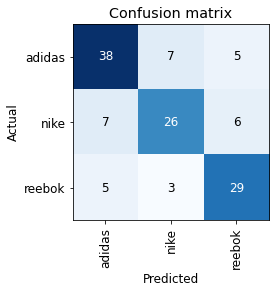

In [55]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [52]:
cleaner = ImageClassifierCleaner(learn)
cleaner

/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [56]:
learn.export()

In [57]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [58]:
learn_inf = load_learner(path/'export.pkl')

In [62]:
learn_inf.predict('images/adidas.jpg')

('adidas', tensor(0), tensor([0.5526, 0.4458, 0.0016]))

In [59]:
learn_inf.dls.vocab

['adidas', 'nike', 'reebok']

In [60]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [61]:
img = PILImage.create(btn_upload.data[-1])

In [62]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [63]:
pred,pred_idx,probs = learn_inf.predict(img)

In [64]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred} | Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: nike | Probability: 0.9890')

In [65]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [66]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred} | Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [67]:
btn_upload = widgets.FileUpload()

In [68]:
VBox([widgets.Label('Upload a picture of shoes [ Nike | Adidas | Reebok ]: '), 
      btn_upload, btn_run, out_pl, lbl_pred])

In [69]:
 !pip install voila
!jupyter serverextension enable --sys-prefix voila

  Using cached nbconvert-6.0.7-py3-none-any.whl (552 kB)
  Attempting uninstall: nbconvert
    Found existing installation: nbconvert 5.6.1
    Uninstalling nbconvert-5.6.1:
      Successfully uninstalled nbconvert-5.6.1
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

nbdev 1.1.5 requires nbconvert<6, but you'll have nbconvert 6.0.7 which is incompatible.
Enabling: voila
- Writing config: /opt/conda/envs/fastai/etc/jupyter
    - Validating...
      voila 0.2.6 OK
